# Contextual Word Embeddings

Como hemos visto, algoritmos como word2vec, GloVe o fastText aprenden a calcular de manera no supervisada representaciones continuas de palabras o de segmentos de palabras. Sin embargo, estas representaciones son estáticas y no tienen en cuenta los distintos significados que una misma palabra pueda tener.

Y el lenguaje natural está repleto de ambigüedades, a varios niveles, y existen fenómenos como la **polisemia** y la **homografía**, que implican que una misma cadena de caracteres pueda tener más de un significado.

- *banco*: de sentar, de crédito, de peces, de arena
- *cubo*: de agua, operación matemática, figura geométrica
- *planta*: arbusto, fábrica, del pie
- *bajo*: nombre, adjetivo, preposición

¿No sería más lógicp asignar diferentes embeddigs teniendo en cuenta los distintos significados?

## ELMo: Embeddings from Language Models

![](img/elmo.gif)

[ELMo](https://allennlp.org/elmo) (Peters et al., 2018) es una nueva técnica del [Allen Institue for AI](https://allennlp.org/) para calcular y asignar vectores de palabras de manera dinámica. ELMo procesa la oración de entrada completa y utiliza dos redes neuronales de tipo LSTM bidireccionales para calcular el embedding de cada palabra atendiendo tanto a su contexto anterior como posterior.

Las representaciones que proporcina ELMo son:

- contextuales: la representación de la palabra depende del contexto de uso
- profundas: combinan la información de varias capas de las LSTM
- basadas en caracteres

El [entrenamiento de ELMo](https://jalammar.github.io/illustrated-bert/#elmo-context-matters) consiste en entrenar las redes neuronales para predecir cuál es la siguiente palabra atendiendo a una secuencia de palabras, lo que da como resultado un **modelo de lenguaje**. 

![](img/elmo-training-lm.png)



In [ ]:
from flair.embeddings import ELMoEmbeddings

# init embedding
vectorizer = ELMoEmbeddings("small")

# create a sentence
sentence = Sentence("The grass is green .")

# embed words in sentence
embedding = vectorizer.embed(sentence)

embedding.shape

In [ ]:
from flair.embeddings import FlairEmbeddings, StackedEmbeddings

# init Flair embeddings
flair_forward_embedding = FlairEmbeddings("multi-forward")
flair_backward_embedding = FlairEmbeddings("multi-backward")

# now create the StackedEmbedding object that combines all embeddings
stacked_embeddings = StackedEmbeddings(
    embeddings=[flair_forward_embedding, flair_backward_embedding, bert_embedding]
)

sentence = Sentence("The grass is green .")

# just embed a sentence using the StackedEmbedding as you would with any single embedding.
stacked_embeddings.embed(sentence)

# now check out the embedded tokens.
for token in sentence:
    print(token)
    print(token.embedding)

## ULMFiT: Universal Language Model Fine-tuning for Text Classification

[ULMFit](http://nlp.fast.ai/classification/2018/05/15/introducing-ulmfit.html), de [fast.ai](https://docs.fast.ai/), es otro de los modelos de lenguaje preentrenados que ha revolucionado el mundo del NLP al permitir implementar de manera muy sencilla técnicas de *transfer learning*.



**¿Qué es el _Transfer Learning_?**

La técnica de ML que consiste no en entrenar un modelo desde cero, sino en usar modelos generalistas pre-entrenados con grandes colecciones de datos y ajustarlos (haciendo *fine tuning*) para resolver una tarea concreta, usando muchos menos datos. 

Este tipo de técnicas se venían utilizando desde hace unos años en el mundo de la visión artificial y con la llegada de ULMFiT se popularizaron también tareas de procesamiento del lenguaje. [NLP's ImageNet moment has arrived](https://ruder.io/nlp-imagenet/), de Sebastian Ruder, es lectura imprescindible.

Es un proceso **semi-supervisado** que se descompone en dos etapas: 

1. parte no supervisada para pre-entrenar un modelo de lenguaje generalista
2. parte supervisada para ajustar el modelo a una tarea concreta (p. ej. clasificación de texto)

En concreto, ULMFiT consiste una red recurrente bidireccional de tipo LSTM (*multi-layer bi-LSTM*) y utilizan algunas novedosas estrategias como:

- *discriminative fine tuning*: durante la etapa de ajuste, en cada capa se aplica un tasa de aprendizaje diferente. Cada capa captura disinto tipo de información y no tiene sentido que las tasa de aprendizaje sea homogénea durante todo el proceso.

- *slanted triangular learning rates (STLR)*: la tasa de aprendizaje se incrementa linealmente para luego descender (_short increase_ -> _long decay_).

- *gradual unfreezing*: durante la etapa de entrenamiento para la tarea de clasificación, se van descongelando las distintas capas empezando por la última y de manera gradual.

In [ ]:
!wget https://raw.githubusercontent.com/sambit9238/Machine-Learning/master/question_topic.csv

In [ ]:
import fastai
from fastai.text import *

import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("question_topic.csv")
train, val = train_test_split(df.sample(200))
train.df()

In [ ]:
# create a language model data bunch
data_lm = TextLMDataBunch.from_df(
    ".", train, val, text_cols="question_text", label_cols="question_topic"
)

In [ ]:
data_lm.show_batch(10)

## BERT: Bidirectional Encoder Representations from Transformers

A finales de 2018, [Google Research presentó BERT](https://github.com/google-research/bert), un nuevo modelo de lenguaje basado en [Transformers](http://www.peterbloem.nl/blog/transformers).

![bert.jpg](img/bert.jpg)

En los meses anteriores se había popularizado en el mundo del Deep Learning un método llamado *Attention*, por los buenísimos resultados que había cosechado en los sistemas de traducción automática. BERT está basado en una nueva arquitectura de DL llamada **Transformer**, que incorpora este mismo mecanismo de *self-attention* para entrenar redes neuronales más rápidamente.

¿Qué otras características novedosas tiene [BERT](https://github.com/google-research/bert#what-is-bert)?

- Es bidireccional: para generar representaciones de cada palabra se tiene en cuenta tanto el contexto anterior como el posterior. Y no combina dos modelos, uno de izquierda a derecha y otro en sentido contrario. Lo hace de una sola vez.
- Para ello utiliza *masking* en algunos tokens y procesa la oración completa.
- Es capaz de aprender relaciones entre oraciones, porque además de predecir las palabras enmascaradas aprende a predecir las siguiente oración. 

Hay varias maneras de acceder a los modelos de BERT pero mis favoritas son:

- [bert as service](https://github.com/hanxiao/bert-as-service), de Tencent.
- [transformers](https://github.com/huggingface/transformers), de Hugging Face 🤗
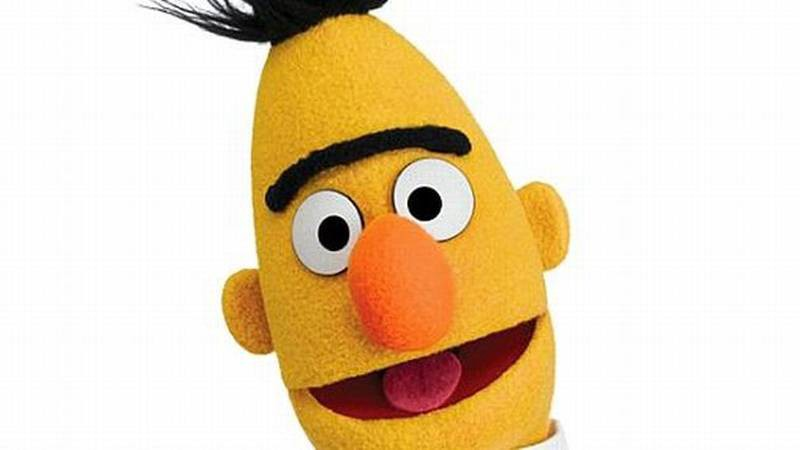

In [ ]:
import torch
from transformers import BertModel, BertTokenizer

MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)

text = "All results on the paper were fine-tuned on a single Cloud TPU."
token_ids = tokenizer.encode(text, add_special_tokens=True)
tokens = tokenizer.convert_ids_to_tokens(token_ids, skip_special_tokens=False)

print(tokens)

In [ ]:
input_ids = torch.tensor([token_ids])

with torch.no_grad():
    last_hidden_states = model(input_ids)[0]

embedding = torch.mean(last_hidden_states, 1)

print(last_hidden_states.shape)
print(embedding.shape)
print(embedding)

## Y más allá

Cada día aparecen nuevos [modelos de lenguaje basados en BERT pre-entrenados en una lengua específica](https://twitter.com/seb_ruder/status/1221851361811128321).

![](img/specific-bert-models.png)

Y modelos de lenguaje basados en otras arquitecturas. No es fácil seguir el ritmo.

![](img/lm-family.jpg)



## Otras Referencias

- [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](https://jalammar.github.io/illustrated-bert/)
- [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
- [Transfer Learning in NLP](https://medium.com/explorations-in-language-and-learning/transfer-learning-in-nlp-2d09c3dfaeb6)
- [Transfer Learning in NLP for Tweet Stance Classification](https://towardsdatascience.com/transfer-learning-in-nlp-for-tweet-stance-classification-8ab014da8dde)